# Name: Aafaq Iqbal Khan   Student ID : x20108851

In [1]:
import findspark
import pyspark
#from pyspark import SparkContext
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as f
from pyspark.sql.functions import *
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark import HiveContext
from pyspark.ml.feature import HashingTF
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.classification import LogisticRegression



import seaborn as sns
import pandas as pd
import re
import matplotlib.pyplot as plt

from pyspark.ml import Pipeline

In [4]:
import pyspark
import time
from pyspark.sql import Row

In [2]:
#SparkSession.stop(spark)
spark=SparkSession.builder.master("local").appName("first").getOrCreate()

In [3]:
#Just for chechking
sc = spark.sparkContext
nums = sc.parallelize([1, 2, 3, 4])
squared = nums.map(lambda x: x * x).collect()
for num in squared:
    print("%i " % (num))

1 
4 
9 
16 


# Load Data from HDFS

In [28]:
df_listing_details = spark.read.csv("/user/hduser/projectData/DIAdata/restaurants_data_from_tripadvisor3.csv", header=True, inferSchema=True, sep=',')

#df_listing_details = spark.read.csv("hdfs://localhost:54310/projectData/DIAdata/restaurants_data_from_tripadvisor3.csv", header=True, sep=',', inferSchema=True)


In [81]:
df_listing_details.show()

+---+---------+--------------------+------+--------+------------+------+-------+-----------+------+--------------------+-------------+--------+-------+---------------+----------+-----------+--------+-------------+--------------+--------------------+----+-----------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|_c0|    ID_TA|                name|closed|inactive|name_changed|rating|claimed|primary_cus|  city|            cuisines|special_diets| pricing|   rank|city_rest_count|is_website|photo_count|is_video|cus_rest_rank|cus_rest_count|             address|mail|              tel|review_number|             reviews|        review_dates|      review_ratings|            orig_url|              URL_TA|
+---+---------+--------------------+------+--------+------------+------+-------+-----------+------+--------------------+-------------+--------+-------+---------------+----------+-----------+--------+-------------+---

For better view

In [172]:
df_listing_details.limit(5).toPandas()

,_c0,ID_TA,name,closed,inactive,name_changed,rating,claimed,primary_cus,city,...,cus_rest_count,address,mail,tel,review_number,reviews,review_dates,review_ratings,orig_url,URL_TA
0,0,d9328394,Pizza School,0.0,0,0,4.0,0.0,Unknown,Seoul,...,None,"224, World Cup Buk-Ro, Seoul South Korea",0.0,+82 2-372-1988,1,None,"February 7, 2017",None,https://www.tripadvisor.com/Restaurant_Review-...,https://www.tripadvisor.com/Restaurant_Review-...
1,1,d9337164,Pujimi Tripes,0.0,0,0,4.5,0.0,Unknown,Seoul,...,None,"23, cheonhoyet14-Gil, Seoul South Korea",0.0,None,3,None,"November 12, 2019 ,February 4, 2019 ,March 27,...",None,https://www.tripadvisor.com/Restaurant_Review-...,https://www.tripadvisor.com/Restaurant_Review-...
2,2,d8956216,Bangung,0.0,0,0,4.5,0.0,Unknown,Seoul,...,None,"17, Gangseo-ro56-Gil, Seoul South Korea",0.0,None,5,None,"February 26, 2020 ,January 15, 2020 ,September...",None,https://www.tripadvisor.com/Restaurant_Review-...,https://www.tripadvisor.com/Restaurant_Review-...
3,3,d9335213,Donsoobaek - Gangnam Station Direct Store,0.0,0,0,4.5,0.0,Asian,Seoul,...,3565.0,"13, Gangnam-daero 110-gil, Gangnam-gu, Seoul 0...",0.0,+82 2-539-3132,7,"Nothing special, but the stew is neat and the ...","February 1, 2018",None,https://www.tripadvisor.com/Restaurant_Review-...,https://www.tripadvisor.com/Restaurant_Review-...
4,4,d9334370,Pork Mo U,0.0,0,0,4.0,0.0,Unknown,Seoul,...,None,"26, Nohae-ro69-Gil, Seoul South Korea",0.0,None,1,None,"October 27, 2017",None,https://www.tripadvisor.com/Restaurant_Review-...,https://www.tripadvisor.com/Restaurant_Review-...


## Columns Selection
Select only rating abd reviews

In [50]:
df=df_listing_details.select("rating","reviews")
df.show(5)

+------+--------------------+
|rating|             reviews|
+------+--------------------+
|   4.0|                null|
|   4.5|                null|
|   4.5|                null|
|   4.5|Nothing special, ...|
|   4.0|                null|
+------+--------------------+
only showing top 5 rows



### Drop any missing value in reviews and ratings

In [51]:
df = df.dropna(how='any')

In [52]:
print((df.count(), len(df.columns)))

(43743, 2)


In [54]:
df = df.withColumn('reviews', translate('reviews', '.', ''))
df = df.withColumn('reviews', translate('reviews', ',', ''))
df = df.withColumn('reviews', translate('reviews', '$', ''))

# Text Cleaning

In [55]:

#tokenize text (make words into an array)
tokenizer = Tokenizer(inputCol='reviews', outputCol='reviews_token')
df_token = tokenizer.transform(df).select('*')

#remove basic words
remover = StopWordsRemover(inputCol='reviews_token', outputCol='reviews_clean')
df_stop=remover.transform(df_token).select('*')

In [56]:
df_stop=df_stop.drop("reviews","reviews_token")
df_stop.show(5)

+------+--------------------+
|rating|       reviews_clean|
+------+--------------------+
|   4.5|[nothing, special...|
|   2.5|[ordered, pizza, ...|
|   5.0|[food, exquisite,...|
|   4.5|[used, cafe, past...|
|   4.5|[locals, italians...|
+------+--------------------+
only showing top 5 rows



In [37]:
df_stop.printSchema()

root
 |-- rating: string (nullable = true)
 |-- reviews_clean: array (nullable = true)
 |    |-- element: string (containsNull = true)



#### Select only those rows that have numbers in ratings

In [57]:
df_clean=df_stop.where((f.col('rating')=='1.0') | (f.col('rating')=='1.5') | (f.col('rating')=='2.0') | (f.col('rating')=='2.5') | (f.col('rating')=='3.0') | (f.col('rating')=='3.5') | (f.col('rating')=='4.0') | (f.col('rating')=='4.5') | (f.col('rating')=='5.0'))

In [58]:
print((df_clean.count(), len(df_clean.columns)))

(42835, 2)


In [44]:
df_clean.distinct().select('rating').show(5)

+------+
|rating|
+------+
|   3.5|
|   5.0|
|   2.5|
|   2.5|
|   4.0|
|   4.5|
|   3.5|
|   3.5|
|   4.5|
|   4.0|
|   3.5|
|   5.0|
|   4.5|
|   3.5|
|   5.0|
|   4.5|
|   5.0|
|   2.5|
|   4.5|
|   5.0|
+------+
only showing top 20 rows



#### Convert string datatype of rating into float

In [59]:
df_clean=df_clean.withColumn('rating',df_clean['rating'].cast("float").alias('rating'))
df_clean.printSchema()

root
 |-- rating: float (nullable = true)
 |-- reviews_clean: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [60]:
df_clean.show()

+------+--------------------+
|rating|       reviews_clean|
+------+--------------------+
|   4.5|[nothing, special...|
|   2.5|[ordered, pizza, ...|
|   5.0|[food, exquisite,...|
|   4.5|[used, cafe, past...|
|   4.5|[locals, italians...|
|   3.5|[eaten, probably,...|
|   4.0|[little, charming...|
|   3.5|[cold, rainy, eve...|
|   4.0|[took, wife, visi...|
|   4.5|[love, place, whe...|
|   4.0|[went, traveling,...|
|   3.5|["love, calabresa...|
|   5.0|[cyc+cg, (, 18110...|
|   4.0|[pourtoi, situate...|
|   5.0|[best, thai, food...|
|   4.5|[first, reviewed,...|
|   5.0|[moon, hyang, res...|
|   3.5|[located, middle,...|
|   4.0|[twosome, cafe, c...|
|   3.5|[original, chicke...|
+------+--------------------+
only showing top 20 rows



Convert spark dataframe into pandas dataframe just to see the distribution.

For modeling we will use spark dataframe

Text(0.5, 1.0, 'Count of Ratings')

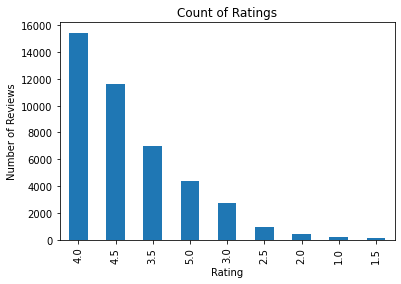

In [82]:
df_pd=df_clean.toPandas()

df_pd.rating.value_counts().plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title("Count of Ratings")


# Classfication Model 

In [63]:
hiveContext = HiveContext(sc)

#df.show(truncate = False)
# Get term frequency vector through HashingTF

ht = HashingTF(inputCol="reviews_clean", outputCol="reviews_features")
result = ht.transform(df_clean)
result.show(2)



+------+--------------------+--------------------+
|rating|       reviews_clean|    reviews_features|
+------+--------------------+--------------------+
|   4.5|[nothing, special...|(262144,[20575,22...|
|   2.5|[ordered, pizza, ...|(262144,[22346,47...|
+------+--------------------+--------------------+
only showing top 2 rows



In [64]:
result=result.drop("reviews_clean")

In [65]:
df_sp = result.withColumn('rating', when(result.rating >= 2.5,1).otherwise(0))

In [67]:

df_vector = VectorAssembler(inputCols=['reviews_features'],
                                          outputCol='features')
df_vector = df_vector.transform(df_sp)

#### Train Test Split

In [68]:
#Train Test Split
seed = 314
train_test = [0.8, 0.2]


data_set = df_vector.select(['features','rating'])
train_df, test_df = data_set.randomSplit(train_test, seed)



### Logistic Regression Model

In [71]:

# Train Logistic Regression Model
log_R = LogisticRegression(labelCol = 'rating').fit(train_df)


#### Prediction on unseen data

In [72]:
test_result = log_R.evaluate(test_df).predictions
test_result.show(3)

+--------------------+------+--------------------+--------------------+----------+
|            features|rating|       rawPrediction|         probability|prediction|
+--------------------+------+--------------------+--------------------+----------+
|(262144,[0,3763,4...|     1|[-682.06447050716...|[6.06965709714188...|       1.0|
|(262144,[4,1097,1...|     1|[-1499.7997182521...|           [0.0,1.0]|       1.0|
|(262144,[5,2296,5...|     1|[-1064.2265884557...|           [0.0,1.0]|       1.0|
+--------------------+------+--------------------+--------------------+----------+
only showing top 3 rows



# Evaluation

In [74]:
# Accuracy computation

tp = test_result[(test_result.rating == 1) & (test_result.prediction == 1)].count()
tn = test_result[(test_result.rating == 0) & (test_result.prediction == 1)].count()
fp = test_result[(test_result.rating == 0) & (test_result.prediction == 1)].count()
fn = test_result[(test_result.rating == 1) & (test_result.prediction == 0)].count()

print('test accuracy is : %f'%((tp+tn)/(tp+tn+fp+fn)))

test accuracy is : 0.974119


In [75]:
# Recall and Precision

print('test recall is : %f'%(tp/(tp+fn)))
print('test precision is : %f'%(tp/(tp+fp)))

test recall is : 0.989754
test precision is : 0.983614


In [76]:
# F1 score

recall = tp/(tp+fn)
precision = tp/(tp+fp)

F1 =  2 * (precision*recall) / (precision + recall)
print('F1 score: %0.3f' % F1)

F1 score: 0.987
